# Signal Preprocessing

## Steps
1. Denoising
    - Skip the first 2 seconds of the signal.
    - High-frequency noise (>40hz).
    - Baseline wander (<0.5hz).
2. Inversion correction
3. Downsampling
    - From 300hz to 100hz.

In [1]:
import configparser
import shutil
from pathlib import Path

import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.signal
import wfdb
from tqdm import tqdm

## Load Config

In [2]:
config = configparser.ConfigParser()
config.read("config.ini")

label_file = Path(config["data_preprocessing"]["label_file"])
src_dir = Path(config["data_preprocessing"]["src_dir"])
dst_dir = Path(config["data_preprocessing"]["dst_dir"])

src_freq = config["data_preprocessing"].getint("src_freq")
dst_freq = config["data_preprocessing"].getint("dst_freq")
skip_time = config.getint("data_preprocessing", "skip_time")
seg_time = config.getint("data_preprocessing", "seg_time")

skip_legnth = src_freq * skip_time
seg_length = dst_freq * seg_time

In [ ]:
sos = scipy.signal.butter(2, [0.5, 40], btype="bandpass", output="sos", fs=src_freq)


def preprocess_signal(signal, freq, dst_freq):
    # skip first few seconds
    signal = signal[skip_legnth:]

    # pad 1 second to both ends to avoid edge effects during filtering
    signal = np.pad(signal, src_freq * 1, "constant", constant_values=0)

    # denoise
    signal = scipy.signal.sosfiltfilt(sos, signal)

    # remove padding
    signal = signal[src_freq * 1 : -src_freq * 1]

    # inversion correction
    signal, _ = nk.ecg_invert(signal, sampling_rate=freq)

    # downsampling
    signal = nk.signal_resample(
        signal, sampling_rate=freq, desired_sampling_rate=dst_freq
    )

    # segmentation
    signal = signal[: len(signal) // seg_length * seg_length]
    segments = signal.reshape(-1, seg_length)

    return segments

In [4]:
# remove existing files and directories
shutil.rmtree(dst_dir, ignore_errors=True)

dst_dir.mkdir(parents=True, exist_ok=True)

# load the dataset
dataset_df = pd.read_csv(label_file, header=None, names=["record_name", "label"])

# load all signals and labels
all_signals: list[np.ndarray] = []
all_labels: list[str] = dataset_df["label"].tolist()
for record_name in tqdm(
    dataset_df["record_name"],
    total=len(dataset_df),
    desc="Loading dataset",
):
    # load signal
    signal, _ = wfdb.rdsamp(src_dir / record_name)
    signal = np.squeeze(signal)
    all_signals.append(signal)

# process the dataset
for record_name, label, signal in tqdm(
    zip(dataset_df["record_name"], all_labels, all_signals),
    total=len(all_labels),
    desc="Processing dataset",
):
    # preprocess the signal
    preprocessed_signal = preprocess_signal(signal, src_freq, dst_freq)

    np.savetxt(dst_dir / f"{record_name}.csv", preprocessed_signal, fmt="%f")

Processing dataset: 100%|██████████| 8528/8528 [01:33<00:00, 91.43it/s] 


## Example

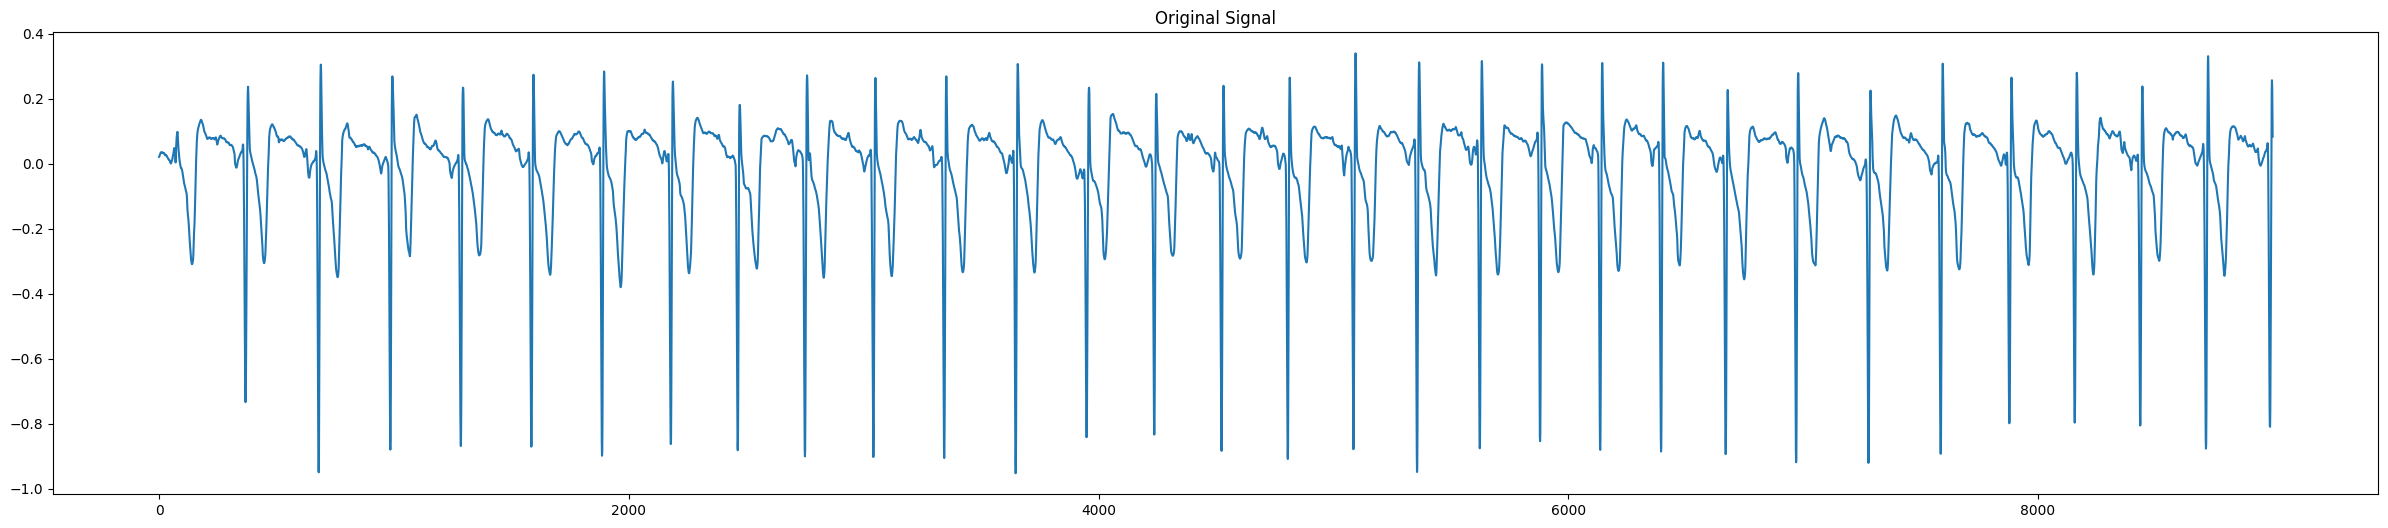

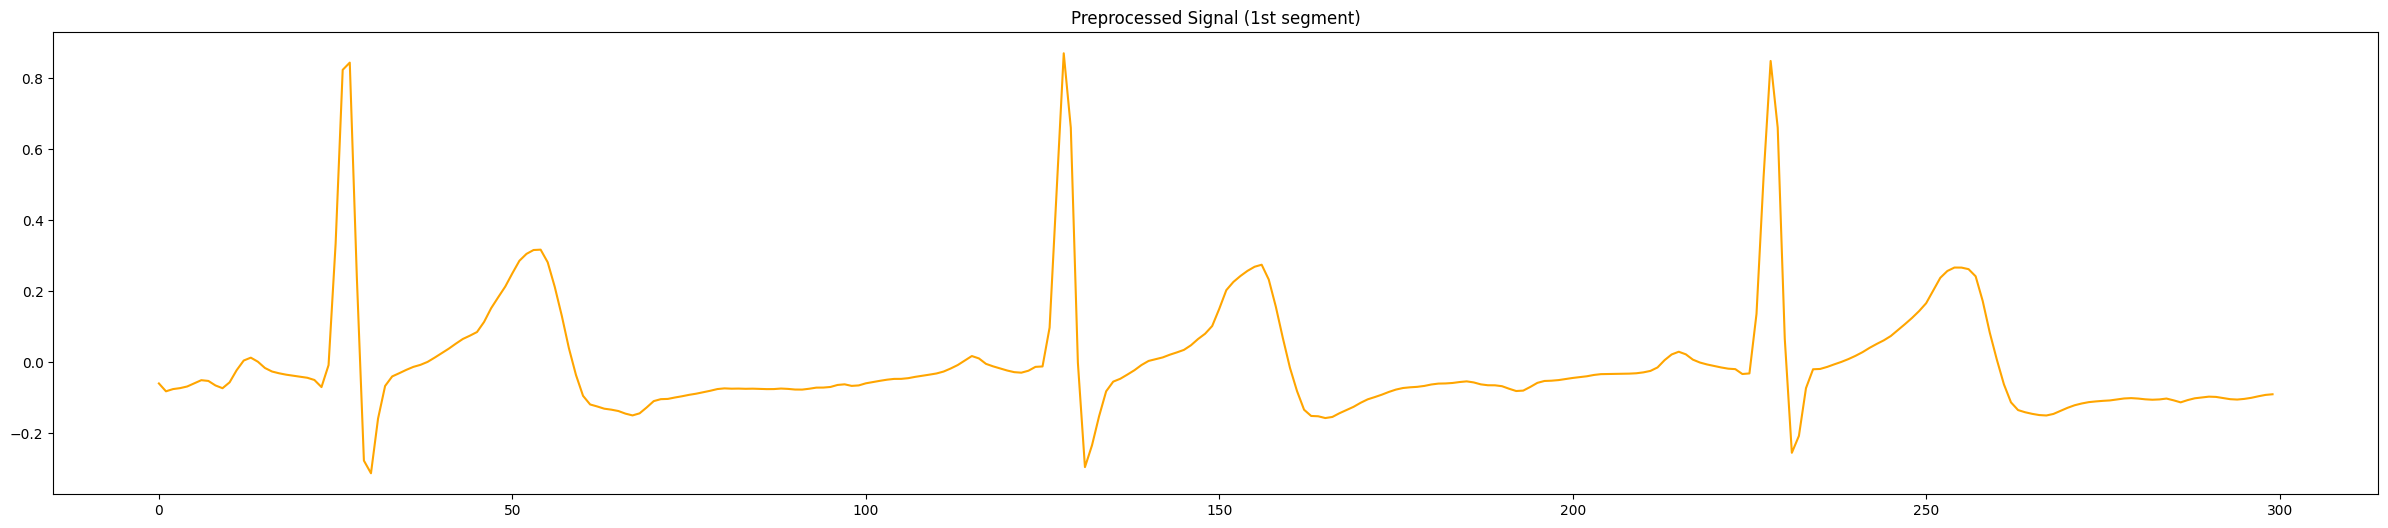

In [5]:
import matplotlib.pyplot as plt

signal, _ = wfdb.rdsamp(src_dir / "A00007")
signal = np.squeeze(signal)
signal_p = np.loadtxt(dst_dir / "A00007.csv")[0]

plt.figure(figsize=(30, 6))
plt.plot(signal, label="")
plt.title("Original Signal")
plt.show()

plt.figure(figsize=(30, 6))
plt.plot(signal_p, label="", color="orange")
plt.title("Preprocessed Signal (1st segment)")
plt.show()